# <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">WOE estimators for PD models</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from scipy.special import expit as sigmoid, logit
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["font.family"] = "Virgil GS"

In [3]:
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

In [4]:
features = [
    'external_risk_estimate',
    'revolving_utilization_of_unsecured_lines',
    'account_never_delinq_percent',
    'net_fraction_revolving_burden',
    'num_total_cc_accounts',
    'average_months_in_file'
    ]

target = 'is_bad'

In [5]:
X = dataset[features + [target]].copy()
y = X.pop("is_bad")
X.replace([-9, -8, -7], np.nan, inplace=True)

ix_train, ix_test = train_test_split(X.index, test_size=0.3, random_state=62)

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">WOE Base Estimator Class</span>

In [218]:
from scipy.special import expit as sigmoid
from sklearn.base import BaseEstimator, ClassifierMixin
from optbinning import BinningProcess
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

class WoeBinner(BaseEstimator, ClassifierMixin):
    """
    Weight-of-Evidence (WOE) Binning Estimator with Optional Interaction Features.

    This class implements a Weight-of-Evidence (WOE) technique for binning data, offering an option to include interaction features. 
    The probability estimation is derived using a linear model:

    log odds = b + w * x1 + w * xi

    where:
    - b represents log odds of default rate, np.log(y.mean() / (1 - y.mean()))
    - w represents feature weight equal to -1

    This class aims to serve as a base estimator for a bagging classifier.

    Parameters:
    -----------
    feature_names : array-like of shape (n_features,)
        Names of the features used for binning.

    include_interactions : bool, default=False
        If True, includes interaction features using PolynomialFeatures.

    Attributes:
    -----------
    binning_process : optbinning.BinningProcess
        An instance of BinningProcess for binning the features.

    bias_woe : float
        Bias term used in the WOE transformation.

    weights_woe : array-like of shape (n_features,)
        Weights used in the WOE transformation.

    poly_features : sklearn.preprocessing.PolynomialFeatures or None
        An instance of PolynomialFeatures used for interaction features if include_interactions is True.

    Methods:
    --------
    fit(X_train, y_train):
        Fits the WOE Binner on the training data.

    transform_to_woe(X):
        Transforms the input features to WOE.

    predict_proba(X):
        Predicts the probabilities for each class label.

    predict(X):
        Predicts binary labels based on the transformed probabilities.

    Examples:
    ---------
    # Usage example
    binner = WoeBinner(feature_names=X.columns, include_interactions=True)
    binner.fit(X_train, y_train)
    probabilities = binner.predict_proba(X_test)
    """
    
    def __init__(self, feature_names, min_prebin_size: float = 0.05, include_interactions=False):
        self.binning_process = None
        self.bias_woe = None
        self.weights_woe = None
        self.feature_names = feature_names
        self.min_prebin_size = min_prebin_size
        self.classes_ = [0, 1]
        self.include_interactions = include_interactions
        self.poly_features = None

    def fit(self, X_train, y_train):
        self.binning_process = BinningProcess(
            variable_names=list(self.feature_names), 
            min_prebin_size=self.min_prebin_size
        )
        self.binning_process.fit(X_train, y_train)

        if self.include_interactions:
            self.poly_features = PolynomialFeatures(
                degree=(1, 5),
                include_bias=False,
                interaction_only=False
            )
            X_train = self.binning_process.transform(X_train)
            X_train = self.poly_features.fit_transform(X_train)

        self.bias_woe = np.log(y_train.mean() / (1 - y_train.mean()))
        self.weights_woe = np.array([-1] * X_train.shape[1])

        return self

    def transform_to_woe(self, X):
        if self.include_interactions:
            X = self.binning_process.transform(X)
            logit_scores = self.poly_features.transform(X)
        else:
            logit_scores = self.binning_process.transform(X)
        return sigmoid(np.dot(logit_scores, self.weights_woe) + self.bias_woe)

    def predict_proba(self, X):
        probabilities = self.transform_to_woe(X)
        return np.column_stack((1 - probabilities, probabilities))

    def predict(self, X):
        probabilities = self.transform_to_woe(X)
        return (probabilities >= 0.5).astype(int)

In [225]:
from sklearn.ensemble import BaggingClassifier

# baseline
clf_baseline = BaggingClassifier(
    estimator=WoeBinner(feature_names=X.columns, min_prebin_size=0.05),
    n_estimators=1,
    bootstrap=False,
    random_state=0
)

clf_baseline.fit(X.loc[ix_train], y.loc[ix_train])

# no interactions - bagging
clf_bagging = BaggingClassifier(
    estimator=WoeBinner(feature_names=X.columns, min_prebin_size=0.05),
    n_estimators=30,
    random_state=0
)

clf_bagging.fit(X.loc[ix_train], y.loc[ix_train])

# with interactions - bagging
clf_bagging_inter = BaggingClassifier(
    estimator=WoeBinner(
        feature_names=X.columns,
        min_prebin_size=0.05,
        include_interactions=True
    ),
    n_estimators=30,
    random_state=0
)

clf_bagging_inter.fit(X.loc[ix_train], y.loc[ix_train])

BaggingClassifier(estimator=WoeBinner(feature_names=Index(['external_risk_estimate', 'revolving_utilization_of_unsecured_lines',
       'account_never_delinq_percent', 'net_fraction_revolving_burden',
       'num_total_cc_accounts', 'average_months_in_file'],
      dtype='object'),
                                      include_interactions=True,
                                      min_prebin_size=0.05),
                  n_estimators=30, random_state=0)

In [ ]:
# baseline
clf_baseline = BaggingClassifier(
    estimator=WoeBinner(feature_names=X.columns),
    n_estimators=1,
    bootstrap=False,
    random_state=0
)

# no interactions - bagging
clf_bagging = BaggingClassifier(
    estimator=WoeBinner(feature_names=X.columns),
    n_estimators=30,
    random_state=0
)

# with interactions - bagging
clf_bagging_inter = BaggingClassifier(
    estimator=WoeBinner(
        feature_names=X.columns,
        include_interactions=True
    ),
    n_estimators=30,
    random_state=0
)

In [226]:
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

def evaluate_classifier(clf, clf_name, X_test, y_test):
    predictions = clf.predict_proba(X_test)[:, 1]
    gini = roc_auc_score(y_test, predictions) * 2 - 1
    logloss = log_loss(y_test, predictions)
    brier = brier_score_loss(y_test, predictions)
    
    print(f"{clf_name}:")
    print(f"Gini: {gini:.2%}")
    print(f"Log Loss: {logloss:.2%}")
    print(f"Brier score: {brier:.2%}")
    print()

# Evaluate classifiers
evaluate_classifier(clf_baseline, 'Baseline', X.loc[ix_test], y.loc[ix_test])
evaluate_classifier(clf_bagging, 'Bagging', X.loc[ix_test], y.loc[ix_test])
evaluate_classifier(clf_bagging_inter, 'Bagging with Interactions', X.loc[ix_test], y.loc[ix_test])

Baseline:
Gini: 86.86%
Log Loss: 17.45%
Brier score: 5.29%

Bagging:
Gini: 88.07%
Log Loss: 16.72%
Brier score: 5.11%

Bagging with Interactions:
Gini: 88.83%
Log Loss: 70.60%
Brier score: 7.55%



In [227]:
%%time
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(clf_bagging_inter, cv=10, method='isotonic')
calibrated_clf.fit(X.loc[ix_train], y.loc[ix_train])

# Evaluate classifier
evaluate_classifier(
    calibrated_clf, 
    'Bagging with Interactions - calibrated', 
    X.loc[ix_test], 
    y.loc[ix_test]
)

Bagging with Interactions - calibrated:
Gini: 88.27%
Log Loss: 16.29%
Brier score: 4.98%

CPU times: user 1min 37s, sys: 11.6 s, total: 1min 49s
Wall time: 1min 14s


### <span style="font-family: Virgil GS, sans-serif; color:navyblue">ROC Curve</span>

In [290]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X.loc[ix_train], y.loc[ix_train])

# Evaluate classifier
evaluate_classifier(
    xgb_model, 
    'XGBoost', 
    X.loc[ix_test], 
    y.loc[ix_test]
)

XGBoost:
Gini: 88.08%
Log Loss: 17.74%
Brier score: 5.09%



In [291]:
clf_list = [
    (clf_baseline, "WOE Baseline"), 
    (clf_bagging, "WOE Bagging"),
    (xgb_model, "XGBoost"),
    (clf_bagging_inter, "WOE Bagging (Interactions)")
    ]

In [315]:
from sklearn.metrics import RocCurveDisplay

plt.rcParams["font.size"] = 22

plt.figure(figsize=(10, 10), dpi=1200)
ax_roc_auc_curve = plt.axes()
colors = plt.colormaps.get_cmap("Set2")

roc_auc_displays = {}

for i, (clf, name) in enumerate(clf_list):
    y_pred = clf.predict_proba(X.loc[ix_test])[:,1]
    gini_score = roc_auc_score(y.loc[ix_test], y_pred) * 2 - 1

    roc_auc_display = RocCurveDisplay.from_estimator(
        clf, 
        X.loc[ix_test],
        y.loc[ix_test], 
        ax=ax_roc_auc_curve, 
        label=f"{name}: {gini_score:.2%}",
        linewidth=3,
        color=colors(i + 1)
    )
    roc_auc_displays[name] = roc_auc_display

ax_roc_auc_curve.set_title('WOE estimators + XGBoost')
ax_roc_auc_curve.grid(alpha=0.5)
ax_roc_auc_curve.plot([0, 1], [0, 1], "k:", linewidth=3)
plt.tight_layout()
plt.savefig('WOE_estimators_xgboost.png', dpi=1200)

### Tuning

/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 95 (_) missing from current font.
  func(*args, **kwargs)
/Users/deburky/Library/Caches/pypoetry/virtualenvs/lr-focal-loss-Opjerf94-py3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 95 (_) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


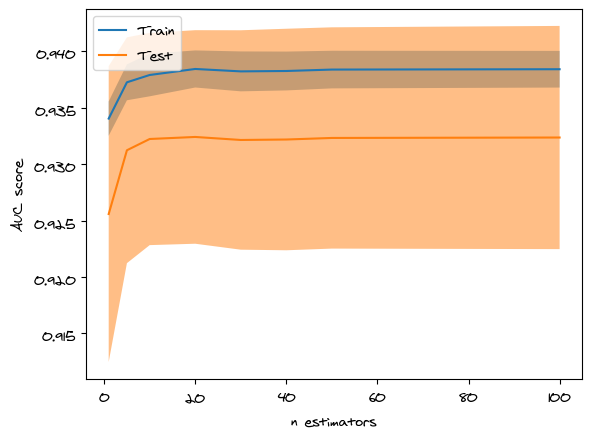

In [137]:
from sklearn.model_selection import ValidationCurveDisplay
from matplotlib import pyplot as plt

n_estimators = np.array([1, 5, 10, 20, 30, 40, 50, 100])

ValidationCurveDisplay.from_estimator(
    clf,
    X.loc[ix_train],
    y.loc[ix_train],
    param_name="n_estimators",
    param_range=n_estimators,
    scoring="roc_auc",
    score_type="both",
    score_name="AUC score",
    cv=5,
    n_jobs=2,
)
plt.xscale('linear')